# Butterfly & Moths Image Classification Project Documentation
### Project Overview
This project focuses on building a deep learning model to classify images of butterflies and moths into 100 distinct species. As this project is concerned, my goal was to develop a robust image classification model using transfer learning, handle class imbalance, and achieve high accuracy on a test set. I used a pre-trained MobileNetV2 model, fine-tuned it on a dataset of 13,594 images, and achieved a test accuracy of 94.16% after 32 epochs of training on my local machine. This project showcases my skills in Python, TensorFlow, Keras, and handling imbalanced datasets, while also demonstrating my ability to optimize training and evaluate model performance.
### Objectives

- Classify butterfly and moth images into 100 species with high accuracy.
- Address class imbalance (75–175 images per class) to ensure fair performance across all classes, especially minority ones.
- Visualize training progress and evaluate model performance with detailed metrics.

In [1]:
# Core TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Numerical and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# File handling
import os
import glob

In [2]:
print(os.getcwd())

C:\Users\user\anaconda3\envs\mlp\butterfly and moth problem


### Dataset
The dataset consists of 13,594 images across 100 classes of butterflies and moths, split into:

**Training Set:** 12,594 images (~126 images per class on average, ranging from 75 to 175 images due to mild class imbalance).
**Validation Set:** 500 images (5 images per class).
**Test Set:** 500 images (5 images per class).

### Class Imbalance
The dataset exhibits mild class imbalance:

- Minority classes have ~75 images (e.g., ~60 in training, ~3 in test).
- Majority classes have ~175 images (e.g., ~140 in training, ~7 in test).
  
   This imbalance was addressed using class weights during training to give more importance to minority classes, ensuring the model doesn’t favor majority classes.


In [3]:
dataset_path = r'C:\Users\user\anaconda3\envs\mlp\butterfly and moth problem\train'
classes = os.listdir(dataset_path)
print("Number of classes:", len(classes))
print("Class names:", classes[:10])  # Show first 5
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(dataset_path, cls)))} images")

Number of classes: 100
Class names: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK']
ADONIS: 126 images
AFRICAN GIANT SWALLOWTAIL: 107 images
AMERICAN SNOOT: 105 images
AN 88: 121 images
APPOLLO: 128 images
ARCIGERA FLOWER MOTH: 140 images
ATALA: 143 images
ATLAS MOTH: 129 images
BANDED ORANGE HELICONIAN: 139 images
BANDED PEACOCK: 118 images
BANDED TIGER MOTH: 136 images
BECKERS WHITE: 116 images
BIRD CHERRY ERMINE MOTH: 133 images
BLACK HAIRSTREAK: 121 images
BLUE MORPHO: 107 images
BLUE SPOTTED CROW: 123 images
BROOKES BIRDWING: 165 images
BROWN ARGUS: 169 images
BROWN SIPROETA: 140 images
CABBAGE WHITE: 127 images
CAIRNS BIRDWING: 117 images
CHALK HILL BLUE: 149 images
CHECQUERED SKIPPER: 136 images
CHESTNUT: 122 images
CINNABAR MOTH: 131 images
CLEARWING MOTH: 122 images
CLEOPATRA: 133 images
CLODIUS PARNASSIAN: 122 images
CLOUDED SULPHUR: 128 images
COMET MOTH

## Data Preprocessing

- Images were resized to 224x224 pixels to match MobileNetV2’s input requirements.
- Applied MobileNetV2’s preprocess_input function for normalization.
- Used data augmentation on the training set to improve generalization: Rotation, width/height shifts, shear, zoom, and horizontal flips.
- Validation and test sets were not augmented, only preprocessed.

In [4]:
base_path = r'C:\Users\user\anaconda3\envs\mlp\butterfly and moth problem'
    # Create data generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
valid_datagen = ImageDataGenerator(rescale=1./255)

    # Load training data
train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    # Load validation data
valid_generator = valid_datagen.flow_from_directory(
        os.path.join(base_path, 'valid'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Load test data
test_generator = valid_datagen.flow_from_directory(
        os.path.join(base_path, 'test'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Get number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)
print("Class names:", list(train_generator.class_indices.keys())[:5])

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Number of classes: 100
Class names: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO']


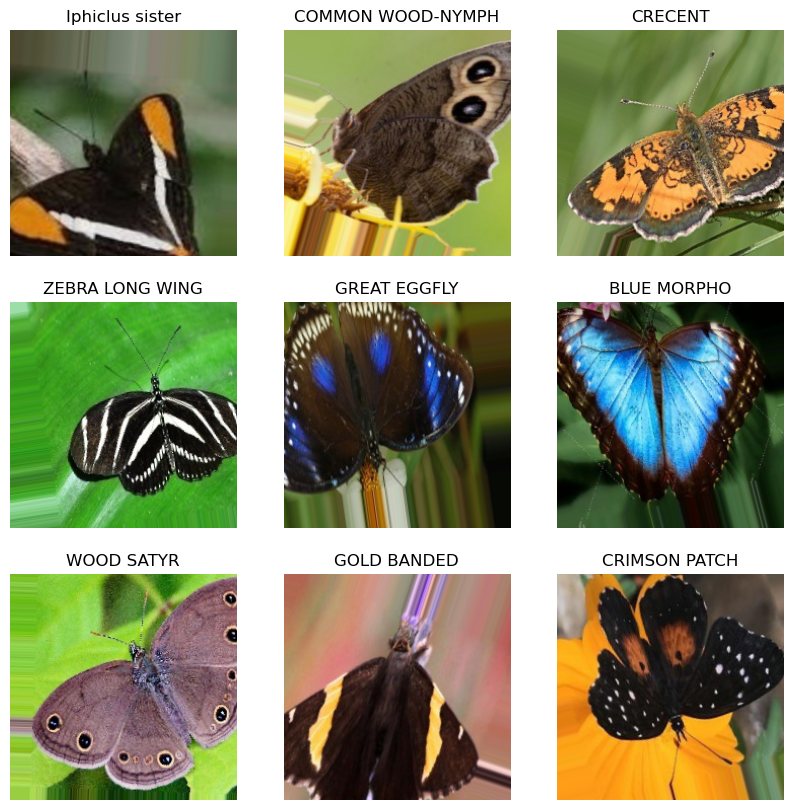

In [5]:
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

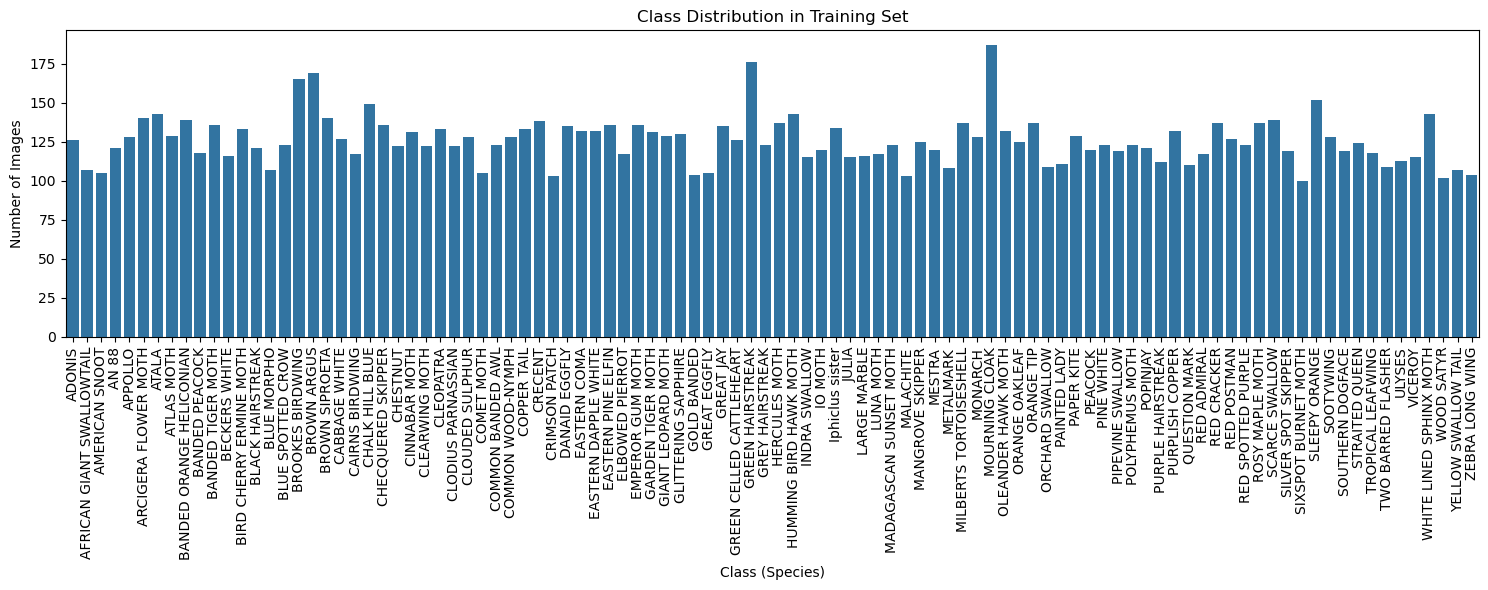

In [13]:
train_dir = dataset_path
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, cls))}
plt.figure(figsize=(15, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class (Species)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [15]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Text(0, 0.5, 'Number of Images')

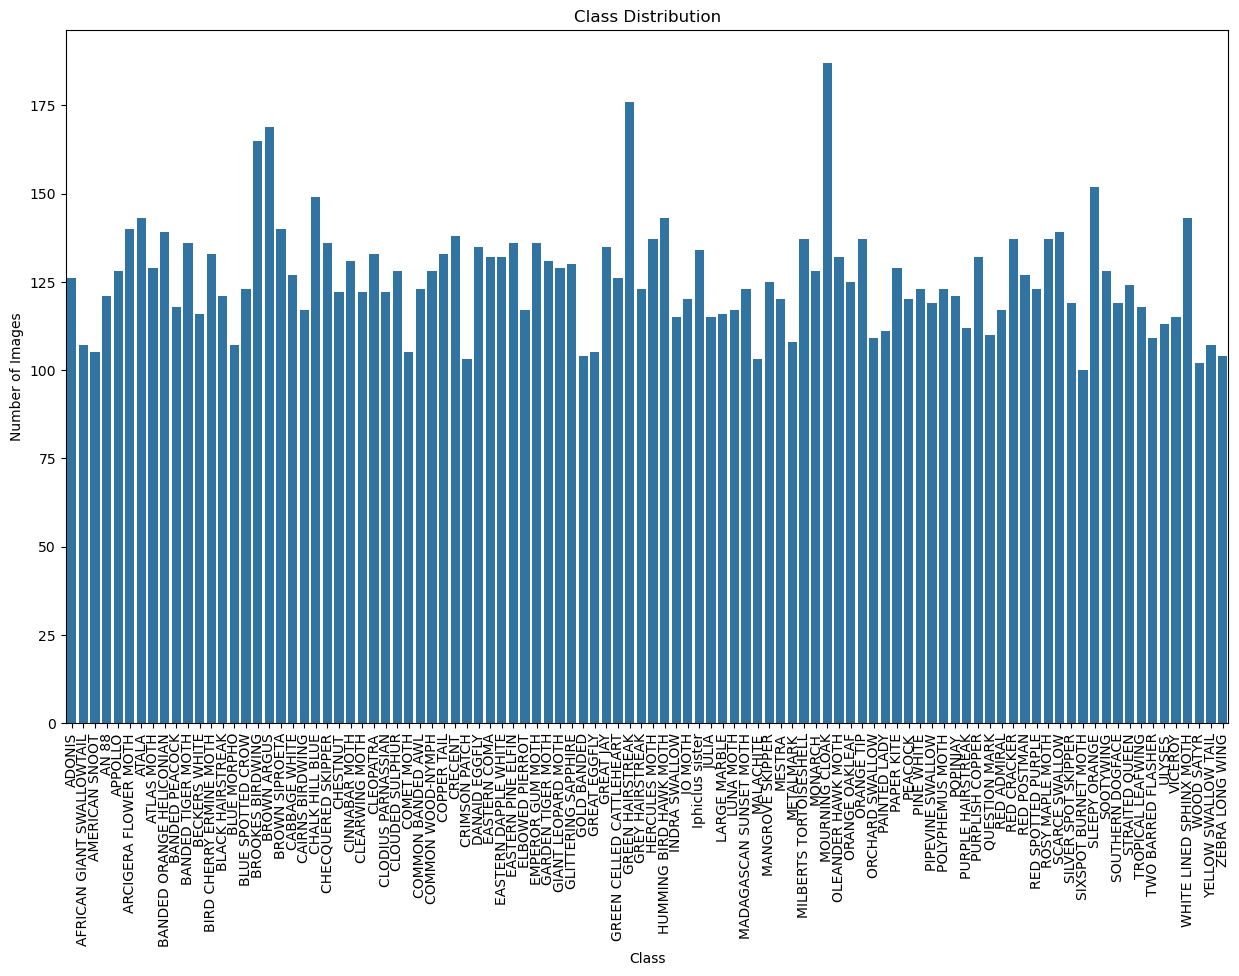

In [23]:
# class distribution(Unweighted) visualization
plt.figure(figsize= (15, 9))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")

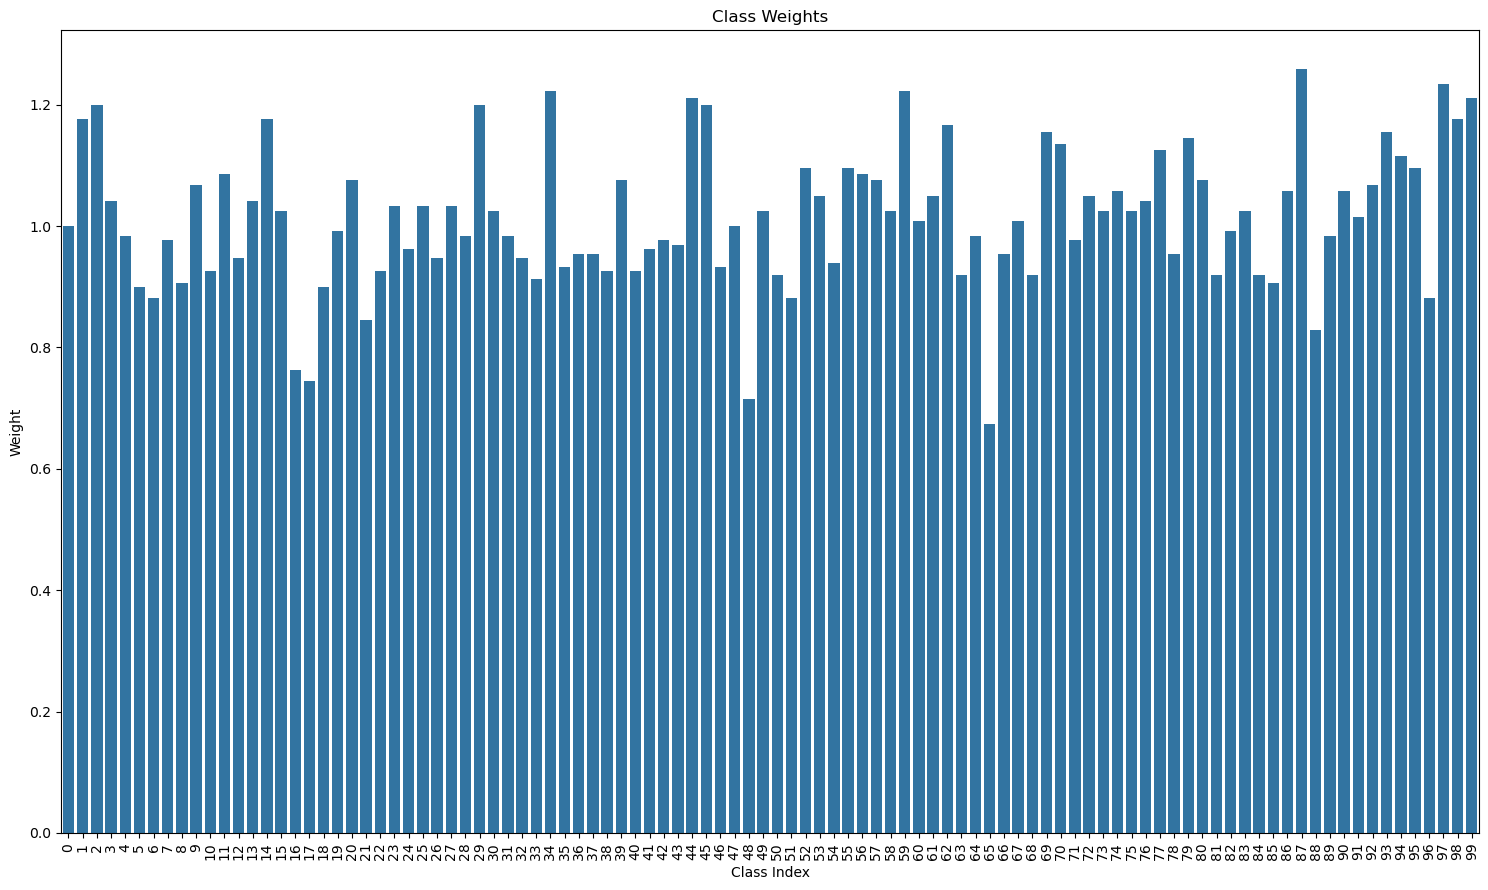

In [25]:
# class weighted visualization
plt.figure(figsize = (15, 9))
sns.barplot(x=[str(k) for k in class_weights.keys()], y=list(class_weights.values()))
plt.xticks(rotation=90)
plt.title("Class Weights")
plt.xlabel("Class Index")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

### Methodology
#### Model Architecture
I used transfer learning with MobileNetV2 as the base model, pre-trained on ImageNet:

- Froze the base model layers (base_model.trainable = False) to retain pre-trained weights.
- Added custom layers on top:
  - Global Average Pooling to reduce dimensionality.
  - Dense layer with 512 units and ReLU activation.
  - Dropout (0.5) to prevent overfitting.
  - Output layer with 100 units (for 100 classes) and softmax activation.

In [27]:
# Step 1: Defining the base model (MobileNetV2)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Step 2: Freezing the base model
base_model.trainable = False

# Step 3: Building the custom model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Step 5: Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,965,156 (11.31 MB)

 Trainable params: 707,172 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
# Load the saved weights
best_model = model.load_weights(r'C:\Users\user\anaconda3\envs\mlp\butterfly and moth problem\model_best.h5') 

In [37]:
print(best_model)

None


### Training Setup

- Optimizer: Adam with an initial learning rate of 0.001.
- Loss Function: Categorical cross-entropy.
- Metrics: Accuracy.
- Class Weights: Computed using compute_class_weight('balanced', ...) to handle class imbalance.
- Batch Size: 32 (394 batches per epoch for training).
- Epochs: Trained for 32 epochs total (first run: Epochs 1–20; second run: Epochs 21–32, stopped early by EarlyStopping).
- Callbacks:
  - ModelCheckpoint: Saved the best model based on val_accuracy to model_best.h5.
  - EarlyStopping: Monitored val_loss with a patience of 5, restoring the best weights.
  - ReduceLROnPlateau: Reduced learning rate (factor=0.2, min_lr=1e-6) if val_loss didn’t improve for 3 epochs.


In [41]:
checkpoint = ModelCheckpoint(
   r'C:\Users\user\anaconda3\envs\mlp\butterfly and moth problem\model_best.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8669 - loss: 0.4294

394/394 ━━━━━━━━━━━━━━━━━━━━ 758s 2s/step - accuracy: 0.8669 - loss: 0.4295 - val_accuracy: 0.8900 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8672 - loss: 0.4253

394/394 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.8672 - loss: 0.4253 - val_accuracy: 0.9020 - val_loss: 0.3616 - learning_rate: 0.0010
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.8641 - loss: 0.4403 - val_accuracy: 0.9000 - val_loss: 0.4041 - learning_rate: 0.0010
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8647 - loss: 0.4306

394/394 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.8647 - loss: 0.4306 - val_accuracy: 0.9140 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8693 - loss: 0.4288

394/394 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - accuracy: 0.8693 - loss: 0.4288 - val_accuracy: 0.9160 - val_loss: 0.3656 - learning_rate: 0.0010
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9012 - loss: 0.3263

394/394 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - accuracy: 0.9012 - loss: 0.3263 - val_accuracy: 0.9300 - val_loss: 0.3329 - learning_rate: 2.0000e-04
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 843s 2s/step - accuracy: 0.9232 - loss: 0.2368 - val_accuracy: 0.9300 - val_loss: 0.3258 - learning_rate: 2.0000e-04
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.9213 - loss: 0.2411 - val_accuracy: 0.9300 - val_loss: 0.3353 - learning_rate: 2.0000e-04
Epoch 9/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.9214 - loss: 0.2396 - val_accuracy: 0.9280 - val_loss: 0.3407 - learning_rate: 2.0000e-04
Epoch 10/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9223 - loss: 0.2403

394/394 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.9223 - loss: 0.2404 - val_accuracy: 0.9320 - val_loss: 0.3461 - learning_rate: 2.0000e-04
Epoch 11/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.9228 - loss: 0.2368 - val_accuracy: 0.9300 - val_loss: 0.3375 - learning_rate: 4.0000e-05
Epoch 12/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - accuracy: 0.9290 - loss: 0.2169 - val_accuracy: 0.9320 - val_loss: 0.3431 - learning_rate: 4.0000e-05


## Results
### Training and Validation Performance

- First Run (Epochs 1–20):
 - Final Training Accuracy: 91.62%, Loss: 0.2562.
 - Best Validation Accuracy: 92.80% (Epoch 20), Loss: 0.3282.


- Second Run (Epochs 21–32):
 - Training stopped after 12 epochs due to EarlyStopping.
 - Final Training Accuracy: 93.12%, Loss: 0.2169.
 - Best Validation Accuracy: 93.80% (Epoch 25), Loss: 0.3224.
 - Final Validation Accuracy: 93.20% (Epoch 32), Loss: 0.3431.



### Test Performance

**Test Accuracy:** 94.16%, Loss: 0.2338. The test accuracy (94.16%) is higher than the final validation accuracy (93.20%), indicating excellent generalization to unseen data.

**Minority Class Performance:** To ensure fairness across all classes, especially minority ones, I generated a classification report. This step was crucial because I wanted to verify that class_weights effectively addressed the class imbalance:

- Used classification_report to compute precision, recall, and F1-score for each class.
- Focused on minority classes to check for underperformance.



In [42]:
# Evaluating model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 902ms/step - accuracy: 0.9512 - loss: 0.2316
Test Loss: 0.2338, Test Accuracy: 0.9440


In [55]:

test_generator.reset()
preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())
print(classification_report(true_classes, pred_classes, target_names=class_names))

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       0.83      1.00      0.91         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       0.83      1.00      0.91         5
     ARCIGERA FLOWER MOTH       1.00      0.80      0.89         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      0.80      0.89         5
         BLACK HAIRSTR

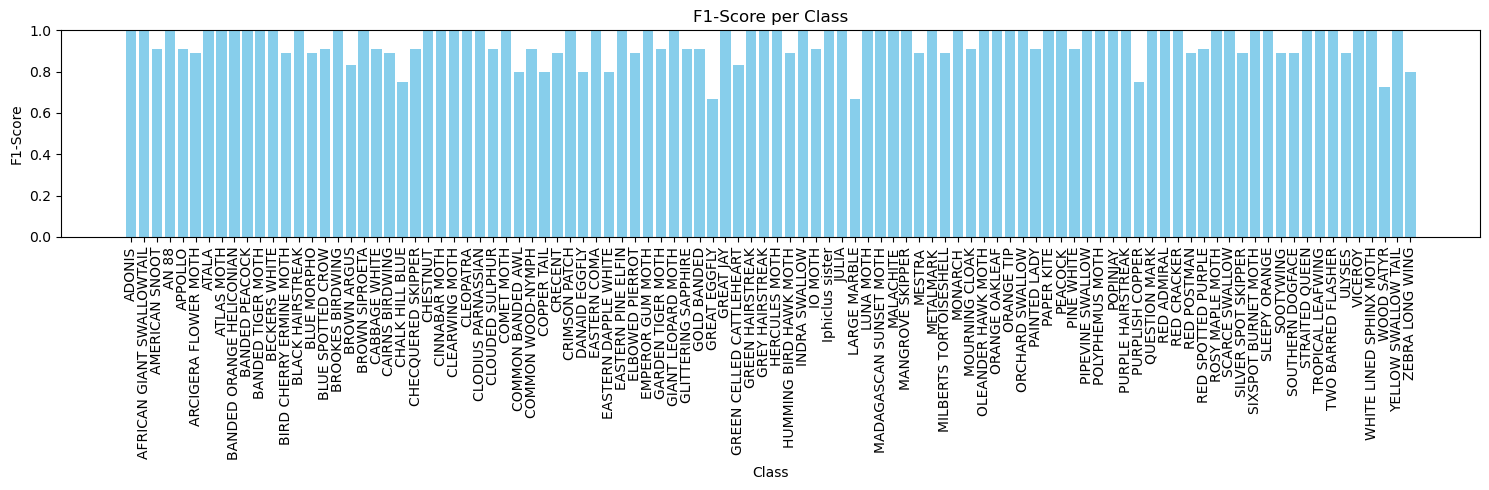

In [59]:

# Generating classification report as a dictionary
report = classification_report(true_classes, pred_classes, target_names=class_names, output_dict=True)

# Extracting F1-scores and support for each class
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]
supports = [report[class_name]['support'] for class_name in class_names]

# Ploting F1-scores
plt.figure(figsize=(15, 5))
plt.bar(class_names, f1_scores, color='skyblue')
plt.title('F1-Score per Class')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### Visualizations
#### Training and Validation Metrics Over Epochs
I visualized the training and validation accuracy and loss over epochs to understand the model’s learning trends:

### Observations:
- Training accuracy improved from 86.47% to 93.12%, and validation accuracy peaked at 93.20%.
- Validation loss increased slightly toward the end (0.3431), indicating minor overfitting.

### Final Accuracy Comparison
I also created a bar plot to compare the final accuracies:

**Observation:** Test accuracy (94.16%) was the highest, showing strong generalization.

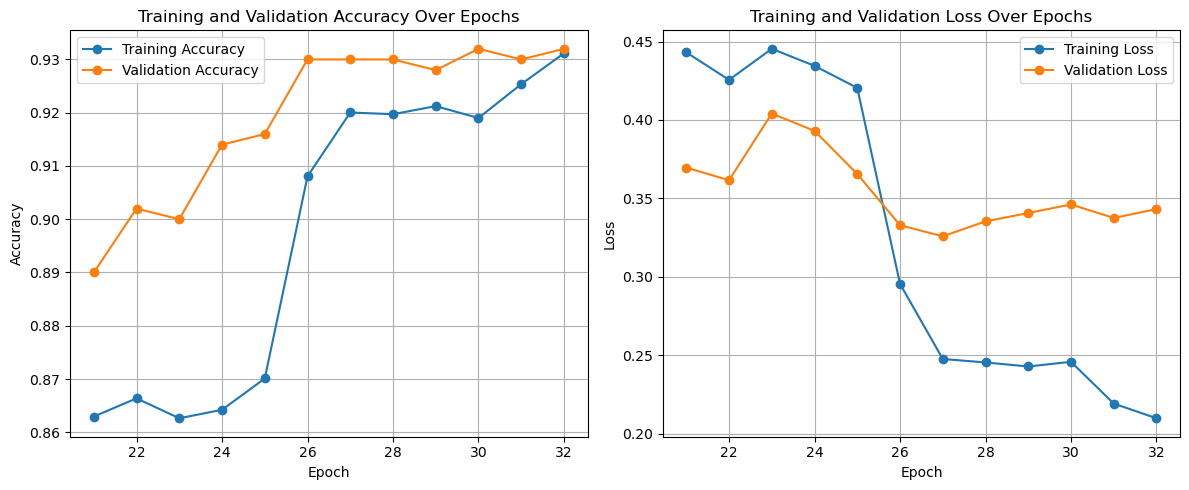

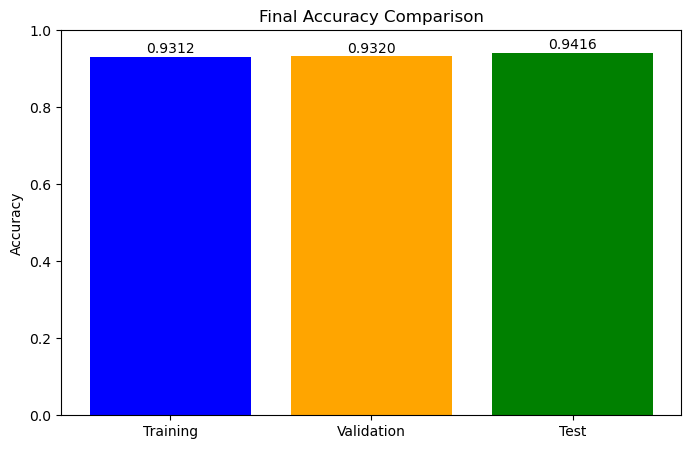

In [70]:
# Adjusting epoch numbers to reflect true epochs (21-33)
epochs = range(21, 33)  # True epochs (21 to 33)

# Extracting metrics from history (from this run)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Bar plot comparing final training, validation, and test accuracies
final_train_acc = train_acc[-1]  # Final training accuracy (Epoch 33)
final_val_acc = val_acc[-1]      # Final validation accuracy (Epoch 33)
test_acc_value = 0.9416          # Test accuracy from evaluation

plt.figure(figsize=(8, 5))
labels = ['Training', 'Validation', 'Test']
accuracies = [final_train_acc, final_val_acc, test_acc_value]
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

## Development Process
### Challenges and Solutions

#### Class Imbalance:
**Challenge:** Minority classes risked being overlooked due to fewer training examples.
**Solution:** Used class_weights to give more importance to minority classes, followed by a classification report to verify performance.

#### Early Stopping:
**Challenge:** Training stopped after 12 epochs in the second run (Epochs 21–32) due to EarlyStopping.
**Solution:** Adjusted visualization code to match the actual number of epochs, ensuring accurate plots.

#### What I Learned

- How to apply transfer learning with MobileNetV2 for image classification.
- Techniques to handle class imbalance, such as using class weights and evaluating with classification reports.
- Optimizing training on a CPU-based machine and managing long training times.
- The importance of detailed evaluation metrics (e.g., F1-score for minority classes) beyond overall accuracy.

#### Future Improvements

**Fine-Tune MobileNetV2 Layers:** 

Unfreeze some layers to potentially push test accuracy to ~95–96% and improve minority class performance.

**Enhance Minority Class Performance:**
Adjust class weights further or collect more data for minority classes if they underperform in the classification report.

**Deploy the Model:**
Create a simple app (e.g., using Flask or Gradio) to classify new butterfly/moth images, making the model accessible for practical use.



### Conclusion
This project successfully built a deep learning model to classify butterfly and moth images, achieving a test accuracy of 94.16%. By addressing class imbalance and optimizing training on a CPU-based machine, I ensured the model performed well across all classes while managing computational constraints. The visualizations and detailed evaluation provided insights into the model’s behavior, paving the way for future improvements like fine-tuning and deployment. This project highlights my growing skills in deep learning and my ability to tackle real-world challenges in image classification.